<a href="https://colab.research.google.com/github/Zine-Elabidine/Transformer-from-scratch/blob/main/Transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Imports



In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn.functional as F

### Positional Encoding and embeddings

In [2]:

class EmbeddingsAndPositionalEncoding(nn.Module):
    def __init__(self, vocab_size, d_model=512, max_len=500):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)

        # Precompute positional encodings up to max_len
        pe = self.create_positional_encoding(max_len, d_model)
        self.register_buffer('pe', pe)

    def create_positional_encoding(self, seq_len, d_model, base=10000):
        position = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(base) / d_model))

        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)  # Apply sin to even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Apply cos to odd indices
        return pe.unsqueeze(0)  # Shape: (1, seq_len, d_model)

    def forward(self, x):
        seq_len = x.size(1)

        if seq_len <= self.pe.size(1):
            # Use precomputed positional encodings
            pe = self.pe[:, :seq_len, :].to(x.device)
        else:
            # Dynamically compute positional encodings if seq_len > max_len
            pe = self.create_positional_encoding(seq_len, self.d_model).to(x.device)

        x = self.embedding(x) + pe
        return x



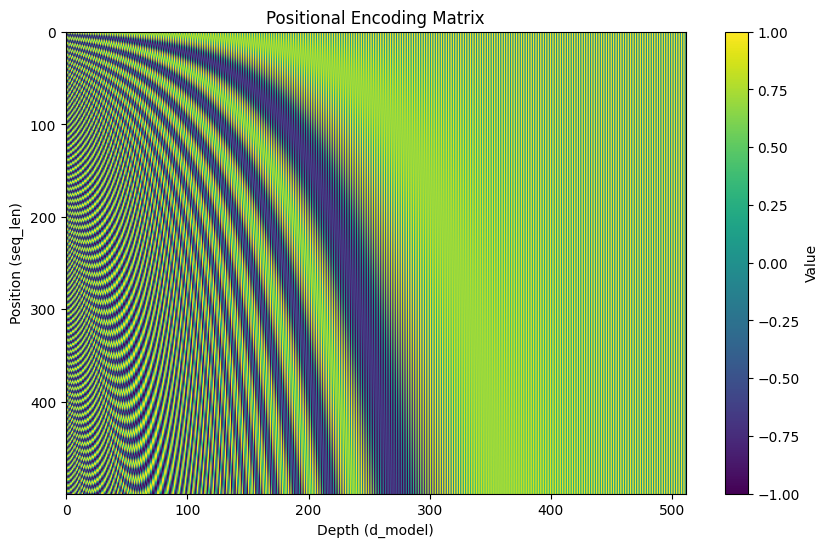

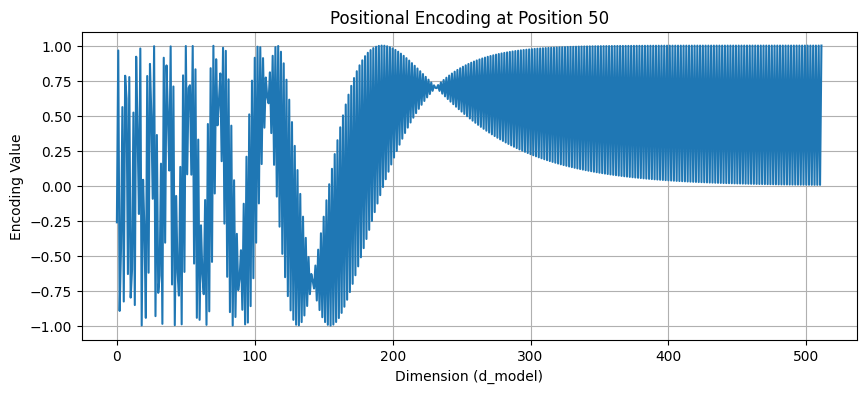

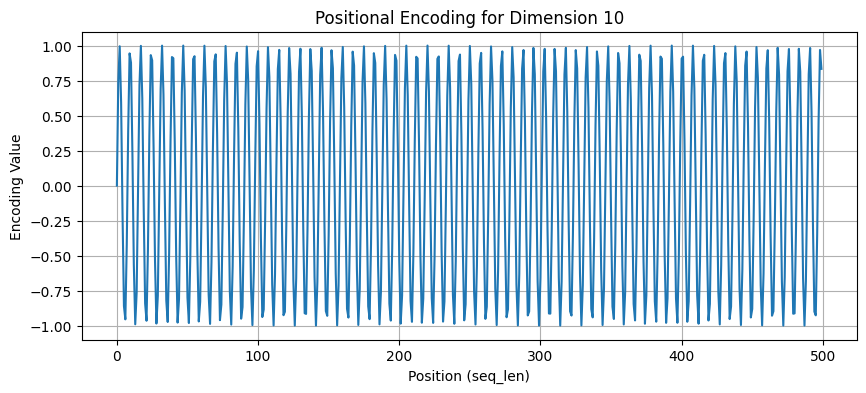

In [3]:
# Create an instance of the class
vocab_size = 10000
d_model = 512
max_len = 500
model = EmbeddingsAndPositionalEncoding(vocab_size, d_model, max_len)

# Generate positional encodings for visualization
pe = model.create_positional_encoding(max_len, d_model).squeeze(0).numpy()  # Shape: (max_len, d_model)

# Visualization 1: Positional Encoding Matrix
plt.figure(figsize=(10, 6))
plt.imshow(pe, cmap='viridis', aspect='auto')
plt.xlabel('Depth (d_model)')
plt.ylabel('Position (seq_len)')
plt.colorbar(label='Value')
plt.title('Positional Encoding Matrix')
plt.show()

# Visualization 2: Positional Encoding for a Single Position
position = 50  # Choose a specific position
plt.figure(figsize=(10, 4))
plt.plot(pe[position, :])
plt.xlabel('Dimension (d_model)')
plt.ylabel('Encoding Value')
plt.title(f'Positional Encoding at Position {position}')
plt.grid()
plt.show()

# Visualization 3: Positional Encoding Across Positions for a Specific Dimension
dimension = 10  # Choose a specific dimension
plt.figure(figsize=(10, 4))
plt.plot(pe[:, dimension])
plt.xlabel('Position (seq_len)')
plt.ylabel('Encoding Value')
plt.title(f'Positional Encoding for Dimension {dimension}')
plt.grid()
plt.show()

# Encoder Blocks

### MHA

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads  # Dimension per head

        # Linear layers for Q, K, V projections
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        # Final output projection after concatenation
        self.w_o = nn.Linear(d_model, d_model)

        # Scaling factor for dot-product attention
        self.scale = self.head_dim ** 0.5

    def forward(self, query, key, value, mask=None):
       #query, key and value here are all X if we are in encoder self attention, x dimension is batch_size,seq_len,d_model
        batch_size, seq_len_q, _ = query.shape   # in cross attention, q seq_len is of the target sequence and k and V are from the encoder
        _, seq_len_k, _ = key.shape
        _, seq_len_v, _ = value.shape

        # Step 1: Linear projections to obtain Q, K, V
        Q = self.w_q(query)  # [batch_size, seq_len_q, d_model]
        K = self.w_k(key)    # [batch_size, seq_len_k, d_model]
        V = self.w_v(value)  # [batch_size, seq_len_v, d_model]

        # Step 2: Reshape to [batch_size, num_heads, seq_len, head_dim]
        Q = Q.view(batch_size, seq_len_q, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len_k, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len_v, self.num_heads, self.head_dim).transpose(1, 2)
        # Now Q, K, V are [batch_size, num_heads, seq_len, head_dim]

        # Step 3: Compute Scaled Dot-Product Attention
        # first reshape K to get the transpose [batch_size, num_heads, head_dim ,seq_len]
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # [batch_size, num_heads, seq_len_q, seq_len_k]

        # Step 4: Apply mask (if provided)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)  # [batch_size, num_heads, seq_len_q, seq_len_k]
        attn_output = torch.matmul(attn_weights, V)  # [batch_size, num_heads, seq_len_q, head_dim]   seq_len_k always equal to seq_len_v

        # Step 5: Concatenate attention heads back to [batch_size, seq_len_q, d_model]
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len_q, self.d_model)

        # Step 6: Apply final linear transformation
        output = self.w_o(attn_output)  # [batch_size, seq_len_q, d_model]

        return output, attn_weights  # Returning attention weights for visualization/debugging

In [6]:

# Hyperparameters
vocab_size = 10000  # Example vocabulary size
d_model = 512       # Embedding dimension
max_len = 500       # Maximum sequence length
batch_size = 2      # Batch size
seq_len = 10        # Sequence length

# Create an instance of the embedding and positional encoding layer
embedding_layer = EmbeddingsAndPositionalEncoding(vocab_size, d_model, max_len)

# Example input (batch_size, seq_len)
x = torch.randint(0, vocab_size, (batch_size, seq_len))

# Forward pass through the embedding layer
x_embedded = embedding_layer(x)
print("Input shape:", x.shape)
print("Embedded output shape:", x_embedded.shape)


# Hyperparameters for multi-head attention
num_heads = 8  # Number of attention heads

# Create an instance of the multi-head attention layer
multi_head_attention = MultiHeadAttention(d_model, num_heads)

# Forward pass through the multi-head attention layer
output, attn_weights = multi_head_attention(x_embedded, x_embedded, x_embedded)

# Print shapes
print("Output shape:", output.shape)
print("Attention weights shape:", attn_weights.shape)

Input shape: torch.Size([2, 10])
Embedded output shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
Attention weights shape: torch.Size([2, 8, 10, 10])


In [7]:
print(multi_head_attention)

MultiHeadAttention(
  (w_q): Linear(in_features=512, out_features=512, bias=True)
  (w_k): Linear(in_features=512, out_features=512, bias=True)
  (w_v): Linear(in_features=512, out_features=512, bias=True)
  (w_o): Linear(in_features=512, out_features=512, bias=True)
)


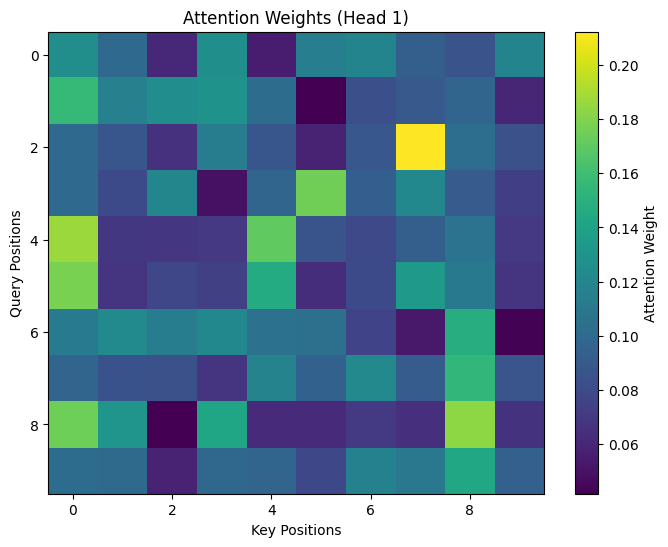

In [8]:
# Plot attention weights for the first example in the batch and the first head
plt.figure(figsize=(8, 6))
plt.imshow(attn_weights[0, 0].detach().numpy(), cmap='viridis', aspect='auto')
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.colorbar(label='Attention Weight')
plt.title('Attention Weights (Head 1)')
plt.show()

### Feed Forward Network

In [9]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff=2048):
        super().__init__()
        self.d_model = d_model  # Store d_model as an attribute
        self.fc1 = nn.Linear(d_model, d_ff)  # First linear layer
        self.fc2 = nn.Linear(d_ff, d_model)  # Second linear layer
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        """
        x: Input tensor of shape (batch_size, seq_len, d_model)
        """
        # Input dimension: (batch_size, seq_len, d_model)
        batch_size, seq_length, d_input = x.size()
        assert self.d_model == d_input, "d_model must be the same dimension as the input"

        # Pass through the feed-forward network
        return self.fc2(self.relu(self.fc1(x)))  # Output shape: (batch_size, seq_len, d_model)


In [10]:
net = FeedForwardNetwork(  d_model = 512,  d_ff =2048)
print(net)

FeedForwardNetwork(
  (fc1): Linear(in_features=512, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (relu): ReLU()
)


### Transformer Encoder

In [11]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048,dropout=0.1):
        super().__init__()

        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForwardNetwork(d_model, d_ff)
        # layer-normalization layer
        self.LayerNorm_att = nn.LayerNorm(d_model)
        self.LayerNorm_ffn = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)  # Dropout for regularization
    def forward(self, x, mask=None):
        """
        x: Input tensor → (batch_size, seq_len, d_model)
        mask: Optional attention mask
        """

        # 1️⃣ Multi-Head Self-Attention + Residual Connection
        attn_output, _ = self.self_attention(x, x, x, mask)  # (batch_size, seq_len, d_model)
        x = self.LayerNorm_att(x + self.dropout(attn_output))  # Add & Norm (batch_size, seq_len, d_model)

        # 2️⃣ Feed-Forward Network + Residual Connection
        ffn_output = self.feed_forward(x)  # (batch_size, seq_len, d_model)
        x = self.LayerNorm_ffn(x + self.dropout(ffn_output))  # Add & Norm (batch_size, seq_len, d_model)

        return x  # Final output: (batch_size, seq_len, d_model)



In [12]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, vocab_size, max_len, dropout=0.1):
        super().__init__()
        self.embedding = EmbeddingsAndPositionalEncoding(vocab_size, d_model, max_len)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])  # Stack multiple encoder layers
        self.norm = nn.LayerNorm(d_model)  # Final LayerNorm

    def forward(self, x, mask=None):
        """
        x: Input token indices → (batch_size, seq_len)
        mask: Padding mask (batch_size, 1, 1, seq_len) (optional)
        """

        # 1️⃣ Embed input tokens + Add positional encoding
        x = self.embedding(x)  # Shape: (batch_size, seq_len, d_model)

        # 2️⃣ Pass through each Transformer Encoder layer
        for layer in self.layers:
            x = layer(x, mask)  # Each layer processes (batch_size, seq_len, d_model)

        return self.norm(x)  # Final LayerNorm output (batch_size, seq_len, d_model)


### Tranformer Decoder

In [13]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)  # Masked Self-Attention
        self.cross_attention = MultiHeadAttention(d_model, num_heads)  # Cross-Attention
        self.feed_forward = FeedForwardNetwork(d_model, d_ff)  # FFN

        # Layer Normalization
        self.LayerNorm_self_attn = nn.LayerNorm(d_model)
        self.LayerNorm_cross_attn = nn.LayerNorm(d_model)
        self.LayerNorm_ffn = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)  # Dropout for regularization

    def forward(self, x, encoder_output, tgt_mask=None, memory_mask=None):
        """
        x: Decoder input (batch_size, tgt_seq_len, d_model)
        encoder_output: Encoder output (batch_size, src_seq_len, d_model)
        tgt_mask: Mask for preventing attention to future tokens in self-attention (batch_size, 1, tgt_seq_len, tgt_seq_len)
        memory_mask: Mask for cross-attention (batch_size, 1, 1, src_seq_len) (optional)
        """

        # 1️⃣ Masked Self-Attention (Prevents looking at future tokens)
        attn_output, _ = self.self_attention(x, x, x, tgt_mask)  # (batch_size, tgt_seq_len, d_model)
        x = self.LayerNorm_self_attn(x + self.dropout(attn_output))  # Add & Norm

        # 2️⃣ Cross-Attention (Attends to Encoder Output)
        attn_output, _ = self.cross_attention(x, encoder_output, encoder_output, memory_mask)  # (batch_size, tgt_seq_len, d_model)
        x = self.LayerNorm_cross_attn(x + self.dropout(attn_output))  # Add & Norm

        # 3️⃣ Feed-Forward Network (FFN)
        ffn_output = self.feed_forward(x)  # (batch_size, tgt_seq_len, d_model)
        x = self.LayerNorm_ffn(x + self.dropout(ffn_output))  # Add & Norm

        return x  # Output: (batch_size, tgt_seq_len, d_model)


In [14]:
class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, vocab_size, max_len, dropout=0.1):
        super().__init__()
        self.embedding = EmbeddingsAndPositionalEncoding(vocab_size, d_model, max_len)  # Token Embedding + Positional Encoding
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])  # Stack multiple decoder layers
        self.norm = nn.LayerNorm(d_model)  # Final LayerNorm
        self.output_layer = nn.Linear(d_model, vocab_size)  # Output layer to map to vocabulary

    def forward(self, x, encoder_output, tgt_mask=None, memory_mask=None):
        """
        x: Decoder input (batch_size, tgt_seq_len)
        encoder_output: Encoder output (batch_size, src_seq_len, d_model)
        tgt_mask: Mask for preventing attention to future tokens in self-attention (batch_size, 1, tgt_seq_len, tgt_seq_len)
        memory_mask: Mask for cross-attention (batch_size, 1, 1, src_seq_len) (optional)
        """

        # 1️⃣ Embed input tokens + Add positional encoding
        x = self.embedding(x)  # Shape: (batch_size, tgt_seq_len, d_model)

        # 2️⃣ Pass through each Transformer Decoder layer
        for layer in self.layers:
            x = layer(x, encoder_output, tgt_mask, memory_mask)  # Each layer processes (batch_size, tgt_seq_len, d_model)

        # 3️⃣ Final LayerNorm
        x = self.norm(x)  # (batch_size, tgt_seq_len, d_model)

        # 4️⃣ Output Layer
        return self.output_layer(x)  # Shape: (batch_size, tgt_seq_len, vocab_size)


### Full Transformer

In [15]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, vocab_size, max_len, dropout=0.1):
        super().__init__()
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, d_ff, vocab_size, max_len, dropout)
        self.decoder = TransformerDecoder(num_layers, d_model, num_heads, d_ff, vocab_size, max_len, dropout)

    def create_padding_mask(self, seq):
        """Create mask for padding tokens (0s)"""
        return (seq != 0).float().unsqueeze(1).unsqueeze(2)

    def create_causal_mask(self, seq_len):
        """Create causal mask to prevent attending to future tokens"""
        mask = torch.triu(torch.ones(seq_len, seq_len, device=self.encoder.embedding.pe.device), diagonal=1) == 0
        return mask.float().unsqueeze(0).unsqueeze(0)

    def create_combined_mask(self, tgt):
        """Create mask that combines padding and causal constraints"""
        seq_len = tgt.size(1)
        padding_mask = self.create_padding_mask(tgt)
        causal_mask = self.create_causal_mask(seq_len)
        return padding_mask * causal_mask

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        src: Source input token indices (batch_size, src_seq_len)
        tgt: Target input token indices (batch_size, tgt_seq_len)
        src_mask: Mask for source input (optional)
        tgt_mask: Mask for target input (optional)
        """
        # Create masks if not provided
        if src_mask is None:
            src_mask = self.create_padding_mask(src)
        if tgt_mask is None:
            tgt_mask = self.create_combined_mask(tgt)

        # 1️⃣ Pass source input through the encoder
        encoder_output = self.encoder(src, src_mask)  # Shape: (batch_size, src_seq_len, d_model)

        # 2️⃣ Pass target input through the decoder with encoder output
        decoder_output = self.decoder(tgt, encoder_output, tgt_mask, src_mask)  # Using src_mask as memory_mask

        return decoder_output  # Final output: (batch_size, tgt_seq_len, vocab_size)


In [22]:
import torch
import torch.nn as nn
import numpy as np

# Hyperparameters for testing
vocab_size = 100  # Small vocabulary size for testing
d_model = 64      # Reduced model dimension for faster testing
num_heads = 4     # Number of attention heads
d_ff = 256        # Feed-forward network dimension
num_layers = 2    # Number of encoder and decoder layers
max_len = 50      # Maximum sequence length
dropout = 0.1     # Dropout rate
batch_size = 2    # Batch size for testing

# Initialize the Transformer model
model = Transformer(num_layers, d_model, num_heads, d_ff, vocab_size, max_len, dropout)

# Create dummy input tensors
src = torch.randint(0, vocab_size, (batch_size, max_len))  # Source sequence (batch_size, src_seq_len)
tgt = torch.randint(0, vocab_size, (batch_size, max_len))  # Target sequence (batch_size, tgt_seq_len)

# Forward pass
output = model(src, tgt)

# Check the output shape
print("Output shape:", output.shape)  # Expected: (batch_size, tgt_seq_len, vocab_size)

# Check if the model is producing valid logits
print("Output logits:", output)

Output shape: torch.Size([2, 50, 100])
Output logits: tensor([[[ 1.3265e+00,  8.2709e-02, -7.4372e-02,  ..., -3.4934e-01,
          -4.5132e-01,  2.3819e-02],
         [ 6.2572e-01, -7.5729e-01,  6.0925e-01,  ...,  3.3943e-01,
           3.6318e-01,  2.7382e-01],
         [ 8.7654e-01, -3.8977e-01, -6.7713e-01,  ...,  8.8761e-01,
          -3.2924e-01, -4.1200e-01],
         ...,
         [ 2.9548e-01, -4.7804e-01, -2.0956e-01,  ..., -3.9210e-01,
          -5.1681e-01,  4.8732e-01],
         [-4.6153e-01, -6.0412e-02, -3.4340e-01,  ..., -2.1651e-01,
          -4.1832e-01,  8.2073e-01],
         [-6.9084e-01, -7.2110e-01, -3.3922e-01,  ..., -1.4299e-02,
          -1.4382e-01,  5.4621e-01]],

        [[ 1.1270e+00,  3.2167e-01,  3.8521e-02,  ...,  3.5630e-01,
          -1.1007e+00, -3.0346e-01],
         [ 9.1088e-01, -5.1378e-01, -2.5562e-01,  ..., -2.9367e-02,
          -1.0480e+00, -3.2182e-01],
         [ 2.0450e-01,  2.1204e-01,  2.6679e-01,  ...,  6.6264e-01,
          -1.2103e-01,

In [17]:
# Sample input (replace with your actual input)
batch_size = 2
src_seq_len = 5
tgt_seq_len = 4
vocab_size = 10  # Example vocab size

# Simulated src and tgt inputs (including padding with 0)
src = torch.tensor([[1, 2, 3, 0, 0],
                    [4, 5, 0, 0, 0]])  # Shape: (batch_size, src_seq_len)

tgt = torch.tensor([[1, 2, 3, 0],
                    [4, 5, 6, 7]])  # Shape: (batch_size, tgt_seq_len)

# Create the transformer model instance
transformer = Transformer(num_layers=6, d_model=512, num_heads=8, d_ff=2048, vocab_size=vocab_size, max_len=10)

# Generate masks
src_mask = transformer.create_padding_mask(src)
tgt_mask = transformer.create_combined_mask(tgt)

# Print masks for inspection
print("Source Mask:\n", src_mask)
print("Target Mask:\n", tgt_mask)

# Pass through the model (optional)
# output = transformer(src, tgt)


Source Mask:
 tensor([[[[1., 1., 1., 0., 0.]]],


        [[[1., 1., 0., 0., 0.]]]])
Target Mask:
 tensor([[[[1., 0., 0., 0.],
          [1., 1., 0., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 0.]]],


        [[[1., 0., 0., 0.],
          [1., 1., 0., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 1.]]]])


In [20]:
import torch
import torch.nn.functional as F

def create_padding_mask(seq):
    """Create mask for padding tokens (0s)"""
    return (seq != 0).float().unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)

def test_padding_mask_on_attention():
    batch_size = 2
    seq_len = 5
    d_model = 4  # Small dimension for simplicity

    # Example input sequences (0 represents padding)
    src = torch.tensor([[1, 2, 3, 0, 0], [4, 5, 0, 0, 0]])

    # Random query, key, value tensors
    Q = torch.randn(batch_size, seq_len, d_model)
    K = torch.randn(batch_size, seq_len, d_model)
    V = torch.randn(batch_size, seq_len, d_model)

    # Compute attention scores (QK^T / sqrt(d_model))
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_model, dtype=torch.float32))

    print("Attention Scores Before Masking:")
    print(scores)

    # Create and apply padding mask
    padding_mask = create_padding_mask(src)  # Shape: (batch_size, 1, 1, seq_len)
    scores = scores.masked_fill(padding_mask == 0, float('-inf'))

    print("Padding Mask shape", padding_mask.size())
    print("Padding Mask", padding_mask)

    print("\nAttention Scores After Applying Padding Mask:")
    print(scores)

    # Apply softmax
    attention_weights = F.softmax(scores, dim=-1)

    print("\nFinal Attention Weights After Softmax:")
    print(attention_weights)

    # Compute final attention output
    attention_output = torch.matmul(attention_weights, V)
    print("\nFinal Attention Output:")
    print(attention_output)

# Run the test
test_padding_mask_on_attention()


Attention Scores Before Masking:
tensor([[[ 4.4137, -3.4273, -0.2024, -1.6210,  0.3143],
         [-1.4553,  1.3222,  1.2638,  0.0556,  0.8947],
         [-2.3272,  1.3594,  1.6575,  1.2305, -0.2337],
         [-1.8074,  1.2542,  0.4618,  0.5441, -0.2590],
         [ 0.1065,  0.0387,  0.4361, -1.5531,  0.3061]],

        [[-3.9475, -3.3166, -0.5050, -0.1626, -0.0151],
         [ 0.5640,  3.1097,  0.1845,  1.3792, -1.6068],
         [-0.0140,  1.3912, -0.2582,  1.1490, -0.9141],
         [ 1.9744, -1.8269, -0.2860, -1.1295,  2.0929],
         [ 0.4185,  0.0991, -0.6319,  1.3841,  0.3391]]])
Padding Mask shape torch.Size([2, 1, 1, 5])
Padding Mask tensor([[[[1., 1., 1., 0., 0.]]],


        [[[1., 1., 0., 0., 0.]]]])

Attention Scores After Applying Padding Mask:
tensor([[[[ 4.4137, -3.4273, -0.2024,    -inf,    -inf],
          [-1.4553,  1.3222,  1.2638,    -inf,    -inf],
          [-2.3272,  1.3594,  1.6575,    -inf,    -inf],
          [-1.8074,  1.2542,  0.4618,    -inf,    -inf],
